In [3]:
# Do some imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from scipy.stats import kurtosis, skew
from scipy.ndimage import laplace, sobel
from skimage.feature import hog


# Load data and process data
data_dir = "data/"

In [4]:
def load_data(data_dir):
    train = pd.read_json(data_dir+"train_with_imfs_full.json")
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    return train

train = load_data(data_dir).sort_index()
train['not_iceberg'] = [1 - x for x in train['is_iceberg'] ]

In [5]:
train.head()

,band_1,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4,id,inc_angle,is_iceberg,not_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-1.0988919319, 1.239443876, 1.409309769, 1.78...","[1.1319092477, -0.32762335470000004, -1.837899...","[-0.7943023179, -0.8981179436000001, -1.022951...","[-0.1155203191, -0.1442084502, -0.1632515676, ...","[-27.154118, -29.537888, -31.0306, -32.190483,...","[4.6054819346, 1.8531034167, -0.44545431350000...","[-1.3913482047, -0.664404976, 0.4903189719, 1....","[-1.1130209481, -1.4270182309, -1.7265201581, ...","[1.2058021648000001, 1.171156506, 1.1340680805...",dfd5f913,43.9239,0,1
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[2.4278357347, -1.3780950106, -2.3385344714, -...","[-2.8254492228, -1.5818709048000001, -0.494550...","[0.7773127355, 0.6550471867000001, 0.528726906...","[-0.7911746286, -0.7220820441, -0.6461949378, ...","[-31.506321, -27.984554, -26.645678, -23.76760...","[-2.6411338709, -0.6127070689, -0.7140450318, ...","[-1.7494047701, -0.5878815036, 0.479933904, 1....","[-0.741042411, -0.5397889651000001, -0.3127055...","[-1.0140161763, -0.8394511398000001, -0.650209...",e25388fd,38.1562,0,1
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-2.3517035974000002, -2.51054499, -2.93708634...","[-0.0752801946, 0.0440600738, 0.1961881336, 0....","[0.0194145331, 0.033636840200000004, 0.0112384...","[-0.1009872598, -0.041155996300000004, 0.02466...","[-24.870956, -24.092632, -20.653963, -19.41104...","[-2.9455213595, -1.7547973947000002, 1.9494347...","[1.8597998744000002, 1.580819666, 1.4414658864...","[1.0314600417, 0.9076466755, 0.7921540198, 0.6...","[0.3392259251, 0.334270454, 0.3289625727, 0.32...",58b2aaa0,45.2859,1,0
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[0.37455575550000003, -0.0223495501, -0.838858...","[0.6327495404, 0.5769199351000001, 0.688552572...","[0.5233987448, 0.3934941993, 0.2324206521, 0.0...","[-0.4771500609, -0.41832076020000003, -0.35662...","[-27.889421, -27.519794, -27.165262, -29.10350...","[0.2930696324, 0.9433731331, 1.4574200848, -0....","[0.2461222513, -0.18240862200000002, -0.442297...","[0.7694352307000001, 0.9417714356, 1.076250828...","[-0.1540494177, -0.17252684610000002, -0.20058...",4cfc3a18,43.8306,0,1
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-1.8041258832, 1.1693541807, 1.0687851578, -2...","[-0.9845684787000001, -0.6014125404, 0.1313275...","[1.8111922429, 1.3180412666, 0.7217794773, 0.1...","[0.28868938040000003, 0.258301443, 0.219260099...","[-27.206915, -30.259186, -30.259186, -23.16495...","[-2.475965787, -4.8733365748, -4.3217468804, 3...","[0.5531354302, -0.0596395318, -0.5264537779, -...","[1.5760187499, 1.5508947953, 1.4858157202, 1.3...","[-0.41642814310000004, -0.43503541830000003, -...",271f93f4,35.6256,0,1


In [60]:
def sub_col(b, i):
    return (np.array(b) - np.array(i)).tolist()

In [61]:
train['band_1_res_1'] = train.apply(lambda row: sub_col(row['band_1'], row['band_1_imf_1']), axis=1)
train['band_1_res_2'] = train.apply(lambda row: sub_col(row['band_1_res_1'], row['band_1_imf_2']), axis=1)
train['band_2_res_1'] = train.apply(lambda row: sub_col(row['band_2'], row['band_2_imf_1']), axis=1)
train['band_2_res_2'] = train.apply(lambda row: sub_col(row['band_2_res_1'], row['band_2_imf_2']), axis=1)

In [51]:
train.head()

,band_1,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4,id,inc_angle,is_iceberg,not_iceberg,band_1_res_1,band_1_res_2,band_2_res_1,band_2_res_2
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-1.0988919319, 1.239443876, 1.409309769, 1.78...","[1.1319092477, -0.32762335470000004, -1.837899...","[-0.7943023179, -0.8981179436000001, -1.022951...","[-0.1155203191, -0.1442084502, -0.1632515676, ...","[-27.154118, -29.537888, -31.0306, -32.190483,...","[4.6054819346, 1.8531034167, -0.44545431350000...","[-1.3913482047, -0.664404976, 0.4903189719, 1....","[-1.1130209481, -1.4270182309, -1.7265201581, ...","[1.2058021648000001, 1.171156506, 1.1340680805...",dfd5f913,43.9239,0,1,"[-26.7794690681, -28.393603876, -30.077924769,...","[-27.9113783158, -28.0659805213, -28.240025762...","[-31.7595999346, -31.3909914167, -30.585145686...","[-30.3682517299, -30.7265864407, -31.075464658..."
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[2.4278357347, -1.3780950106, -2.3385344714, -...","[-2.8254492228, -1.5818709048000001, -0.494550...","[0.7773127355, 0.6550471867000001, 0.528726906...","[-0.7911746286, -0.7220820441, -0.6461949378, ...","[-31.506321, -27.984554, -26.645678, -23.76760...","[-2.6411338709, -0.6127070689, -0.7140450318, ...","[-1.7494047701, -0.5878815036, 0.479933904, 1....","[-0.741042411, -0.5397889651000001, -0.3127055...","[-1.0140161763, -0.8394511398000001, -0.650209...",e25388fd,38.1562,0,1,"[-14.6702107347, -13.5422099894, -12.581828528...","[-11.8447615119, -11.9603390846, -12.087278490...","[-28.8651871291, -27.3718469311, -25.931632968...","[-27.115782359, -26.7839654275, -26.4115668721..."
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-2.3517035974000002, -2.51054499, -2.93708634...","[-0.0752801946, 0.0440600738, 0.1961881336, 0....","[0.0194145331, 0.033636840200000004, 0.0112384...","[-0.1009872598, -0.041155996300000004, 0.02466...","[-24.870956, -24.092632, -20.653963, -19.41104...","[-2.9455213595, -1.7547973947000002, 1.9494347...","[1.8597998744000002, 1.580819666, 1.4414658864...","[1.0314600417, 0.9076466755, 0.7921540198, 0.6...","[0.3392259251, 0.334270454, 0.3289625727, 0.32...",58b2aaa0,45.2859,1,0,"[-22.2519724026, -22.09316901, -21.9339426572,...","[-22.176692208, -22.1372290838, -22.1301307908...","[-21.9254346405, -22.3378346053, -22.603397713...","[-23.7852345149, -23.9186542713, -24.044863599..."
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[0.37455575550000003, -0.0223495501, -0.838858...","[0.6327495404, 0.5769199351000001, 0.688552572...","[0.5233987448, 0.3934941993, 0.2324206521, 0.0...","[-0.4771500609, -0.41832076020000003, -0.35662...","[-27.889421, -27.519794, -27.165262, -29.10350...","[0.2930696324, 0.9433731331, 1.4574200848, -0....","[0.2461222513, -0.18240862200000002, -0.442297...","[0.7694352307000001, 0.9417714356, 1.076250828...","[-0.1540494177, -0.17252684610000002, -0.20058...",4cfc3a18,43.8306,0,1,"[-22.8291627555, -23.0604694499, -23.159154404...","[-23.4619122959, -23.637389385000002, -23.8477...","[-28.1824906324, -28.4631671331, -28.622682084...","[-28.4286128837, -28.2807585111, -28.180384876..."
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-1.8041258832, 1.1693541807, 1.0687851578, -2...","[-0.9845684787000001, -0.6014125404, 0.1313275...","[1.8111922429, 1.3180412666, 0.7217794773, 0.1...","[0.28868938040000003, 0.258301443, 0.219260099...","[-27.206915, -30.259186, -30.259186, -23.16495...","[-2.475965787, -4.8733365748, -4.3217468804, 3...","[0.5531354302, -0.0596395318, -0.5264537779, -...","[1.5760187499, 1.5508947953, 1.4858157202, 1.3...","[-0.41642814310000004, -0.43503541830000003, -...",271f93f4,35.6256,0,1,"[-24.202830116799998, -24.3342401807, -24.2336...","[-23.218261638099996, -23.732827640300002, -24...","[-24.730949213, -25.3858494252, -25.9374391196...","[-25.2840846432, -25.3262098934, -25.410985341..."


In [5]:
# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    X_band1_imf1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1_imf_1"]])
    X_band1_imf2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1_imf_2"]])
    X_band1_imf3 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1_imf_3"]])
    X_band1_imf4 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1_imf_4"]])
    X_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    X_band2_imf1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2_imf_1"]])
    X_band2_imf2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2_imf_2"]])
    X_band2_imf3 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2_imf_3"]])
    X_band2_imf4 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2_imf_4"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis],
                           X_band1_imf1[:, :, :, np.newaxis],
                           X_band1_imf2[:, :, :, np.newaxis],
                           X_band1_imf3[:, :, :, np.newaxis],
                           X_band1_imf4[:, :, :, np.newaxis],
                           X_band2[:, :, :, np.newaxis],
                           X_band2_imf1[:, :, :, np.newaxis],
                           X_band2_imf2[:, :, :, np.newaxis],
                           X_band2_imf3[:, :, :, np.newaxis],
                           X_band2_imf4[:, :, :, np.newaxis],
                           ], axis=-1)
    return imgs

X_train = process_images(train)

X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

In [6]:
X_train.shape

(1604, 75, 75, 10)

In [6]:
def get_feat_vec(img):
    return np.var(hog(img[15:60,15:60], orientations=9, pixels_per_cell=(15, 15), cells_per_block=(1, 1)))

In [7]:
def get_stats(train,label=1,imf=0, res=0):
    band_name = 'band_' + str(label)
    if imf != 0:
        band_name = 'band_' + str(label) + '_imf_' + str(imf)
    elif res != 0:
        band_name = 'band_' + str(label) + '_res_' + str(res)
    train['max'+str(label)] = [np.max(np.array(x)) for x in train[band_name] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train[band_name] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train[band_name] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train[band_name] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train[band_name] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train[band_name] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train[band_name] ]
    train['laplace'+str(label)] = [laplace(np.array(x).astype(np.float32).reshape(75, 75), mode='reflect', cval=0.0).ravel().var() for x in train[band_name] ]
    train['sobel0_'+str(label)] = [sobel(np.array(x).astype(np.float32).reshape(75, 75), axis=0, mode='reflect', cval=0.0).ravel().var() for x in train[band_name] ]
    train['sobel1_'+str(label)] = [sobel(np.array(x).astype(np.float32).reshape(75, 75), axis=1, mode='reflect', cval=0.0).ravel().var() for x in train[band_name] ]
    train['kurtosis'+str(label)] = [kurtosis(np.array(x).astype(np.float32).reshape(75, 75).ravel()) for x in train[band_name] ]
    train['skewness'+str(label)] = [skew(np.array(x).astype(np.float32).reshape(75, 75).ravel()) for x in train[band_name] ]
    train['feature_vector'+str(label)] = [get_feat_vec(np.array(x).astype(np.float32).reshape(75, 75)) for x in train[band_name] ]
            
    return train

In [8]:
columns = [ 'min1', 'min2', 'max1', 'max2',
          'std1', 'std2', 'med1', 'med2',
          'mean1', 'mean2', 'laplace1', 'laplace2',
          'sobel0_1', 'sobel0_2', 'sobel1_1', 'sobel1_2',
          'kurtosis1', 'kurtosis2', 'skewness1', 'skewness2'
        ]

In [56]:
train = get_stats(train,1)
train = get_stats(train,2)
train[['is_iceberg','not_iceberg','id', 'inc_angle'] + columns].to_csv('data/features_bands.csv')
train = get_stats(train,1, imf=1)
train = get_stats(train,2, imf=1)
train[['is_iceberg','not_iceberg','id', 'inc_angle'] + columns].to_csv('data/features_imf_1.csv')
train = get_stats(train,1, imf=2)
train = get_stats(train,2, imf=2)
train[['is_iceberg','not_iceberg','id', 'inc_angle'] + columns].to_csv('data/features_imf_2.csv')
train = get_stats(train,1, res=1)
train = get_stats(train,2, res=1)
train[['is_iceberg','not_iceberg','id', 'inc_angle'] + columns].to_csv('data/features_res_1.csv')
train = get_stats(train,1, res=2)
train = get_stats(train,2, res=2)
train[['is_iceberg','not_iceberg','id', 'inc_angle'] + columns].to_csv('data/features_res_2.csv')

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [9]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

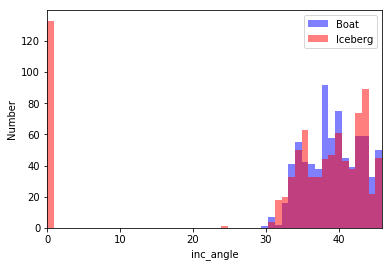

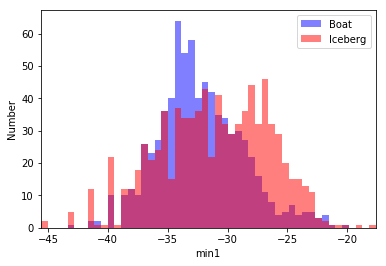

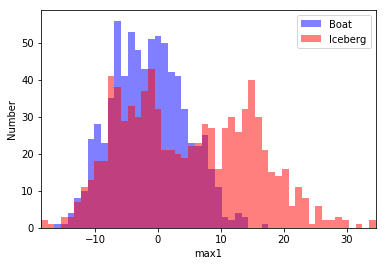

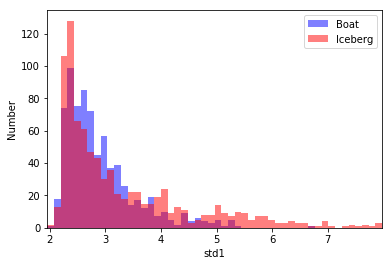

In [ ]:
for col in [columns]:
    plot_var(col)

In [5]:
train.head()

,band_1,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4,id,inc_angle,is_iceberg,not_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-1.0988919319, 1.239443876, 1.409309769, 1.78...","[1.1319092477, -0.32762335470000004, -1.837899...","[-0.7943023179, -0.8981179436000001, -1.022951...","[-0.1155203191, -0.1442084502, -0.1632515676, ...","[-27.154118, -29.537888, -31.0306, -32.190483,...","[4.6054819346, 1.8531034167, -0.44545431350000...","[-1.3913482047, -0.664404976, 0.4903189719, 1....","[-1.1130209481, -1.4270182309, -1.7265201581, ...","[1.2058021648000001, 1.171156506, 1.1340680805...",dfd5f913,43.9239,0,1
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[2.4278357347, -1.3780950106, -2.3385344714, -...","[-2.8254492228, -1.5818709048000001, -0.494550...","[0.7773127355, 0.6550471867000001, 0.528726906...","[-0.7911746286, -0.7220820441, -0.6461949378, ...","[-31.506321, -27.984554, -26.645678, -23.76760...","[-2.6411338709, -0.6127070689, -0.7140450318, ...","[-1.7494047701, -0.5878815036, 0.479933904, 1....","[-0.741042411, -0.5397889651000001, -0.3127055...","[-1.0140161763, -0.8394511398000001, -0.650209...",e25388fd,38.1562,0,1
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-2.3517035974000002, -2.51054499, -2.93708634...","[-0.0752801946, 0.0440600738, 0.1961881336, 0....","[0.0194145331, 0.033636840200000004, 0.0112384...","[-0.1009872598, -0.041155996300000004, 0.02466...","[-24.870956, -24.092632, -20.653963, -19.41104...","[-2.9455213595, -1.7547973947000002, 1.9494347...","[1.8597998744000002, 1.580819666, 1.4414658864...","[1.0314600417, 0.9076466755, 0.7921540198, 0.6...","[0.3392259251, 0.334270454, 0.3289625727, 0.32...",58b2aaa0,45.2859,1,0
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[0.37455575550000003, -0.0223495501, -0.838858...","[0.6327495404, 0.5769199351000001, 0.688552572...","[0.5233987448, 0.3934941993, 0.2324206521, 0.0...","[-0.4771500609, -0.41832076020000003, -0.35662...","[-27.889421, -27.519794, -27.165262, -29.10350...","[0.2930696324, 0.9433731331, 1.4574200848, -0....","[0.2461222513, -0.18240862200000002, -0.442297...","[0.7694352307000001, 0.9417714356, 1.076250828...","[-0.1540494177, -0.17252684610000002, -0.20058...",4cfc3a18,43.8306,0,1
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-1.8041258832, 1.1693541807, 1.0687851578, -2...","[-0.9845684787000001, -0.6014125404, 0.1313275...","[1.8111922429, 1.3180412666, 0.7217794773, 0.1...","[0.28868938040000003, 0.258301443, 0.219260099...","[-27.206915, -30.259186, -30.259186, -23.16495...","[-2.475965787, -4.8733365748, -4.3217468804, 3...","[0.5531354302, -0.0596395318, -0.5264537779, -...","[1.5760187499, 1.5508947953, 1.4858157202, 1.3...","[-0.41642814310000004, -0.43503541830000003, -...",271f93f4,35.6256,0,1


In [51]:
titles = {
    'min1': 'Minimum - band 1', 'min2': 'Minimum - band 2',
    'max1': 'Maximum - band 1', 'max2': 'Maximum - band 2',
    'std1': 'Standard deviation - band 1', 'std2': 'Standard deviation - band 2',
    'med1': 'Median - band 1', 'med2': 'Median - band 2',
    'mean1': 'Mean - band 1', 'mean2': 'Mean - band 2',
    'laplace1': 'Variance of Laplace filtered image - band 1', 'laplace2': 'Variance of Laplace filtered image - band 2',
    'sobel0_1': 'Variance of Sobel filtered image in x-axis - band 1', 'sobel0_2': 'Variance of Sobel filtered image in x-axis - band 2',
    'sobel1_1': 'Variance of Sobel filtered image in y-axis - band 1', 'sobel1_2': 'Variance of Sobel filtered image in y-axis - band 2',
    'kurtosis1': 'Kurtosis - band 1', 'kurtosis2': 'kurtosis - band 2',
    'skewness1': 'Skewness - band 1', 'skewness2': 'Skewness - band 2'
}
xlabel = {
    'min1': 'minimum', 'min2': 'minimum',
    'max1': 'maximum', 'max2': 'maximum',
    'std1': 'standard deviation', 'std2': 'standard deviation',
    'med1': 'median', 'med2': 'median',
    'mean1': 'mean', 'mean2': 'mean',
    'laplace1': 'variance', 'laplace2': 'variance',
    'sobel0_1': 'variance', 'sobel0_2': 'variance',
    'sobel1_1': 'variance', 'sobel1_2': 'variance',
    'kurtosis1': 'kurtosis', 'kurtosis2': 'Kurtosis',
    'skewness1': 'skewness', 'skewness2': 'skewness'
}
def big_plot(names, size, nbins=50):
    fig, ax = plt.subplots(size[0], size[1], figsize=(25,20))
    fig.tight_layout(h_pad=5)
    for i, ax in enumerate(np.ravel(ax)):
        name = names[i]
        minval = train[name].min()
        maxval = train[name].max()
        ax.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
                 bins=nbins,color=(0,0,0), edgecolor='gray',alpha=1,label='Boat')
        ax.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
                 bins=nbins,color=(1,1,1), edgecolor='black',alpha=0.5,label='Iceberg')
        ax.legend()
        ax.set_title(titles[name], fontsize=16)
        ax.set_xlim([minval,maxval])
        ax.set_xlabel(xlabel[name], fontsize=16)
        ax.set_ylabel('Number', fontsize=16)
    plt.show()
    fig.savefig("plots/distributions.pdf", format="pdf")

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


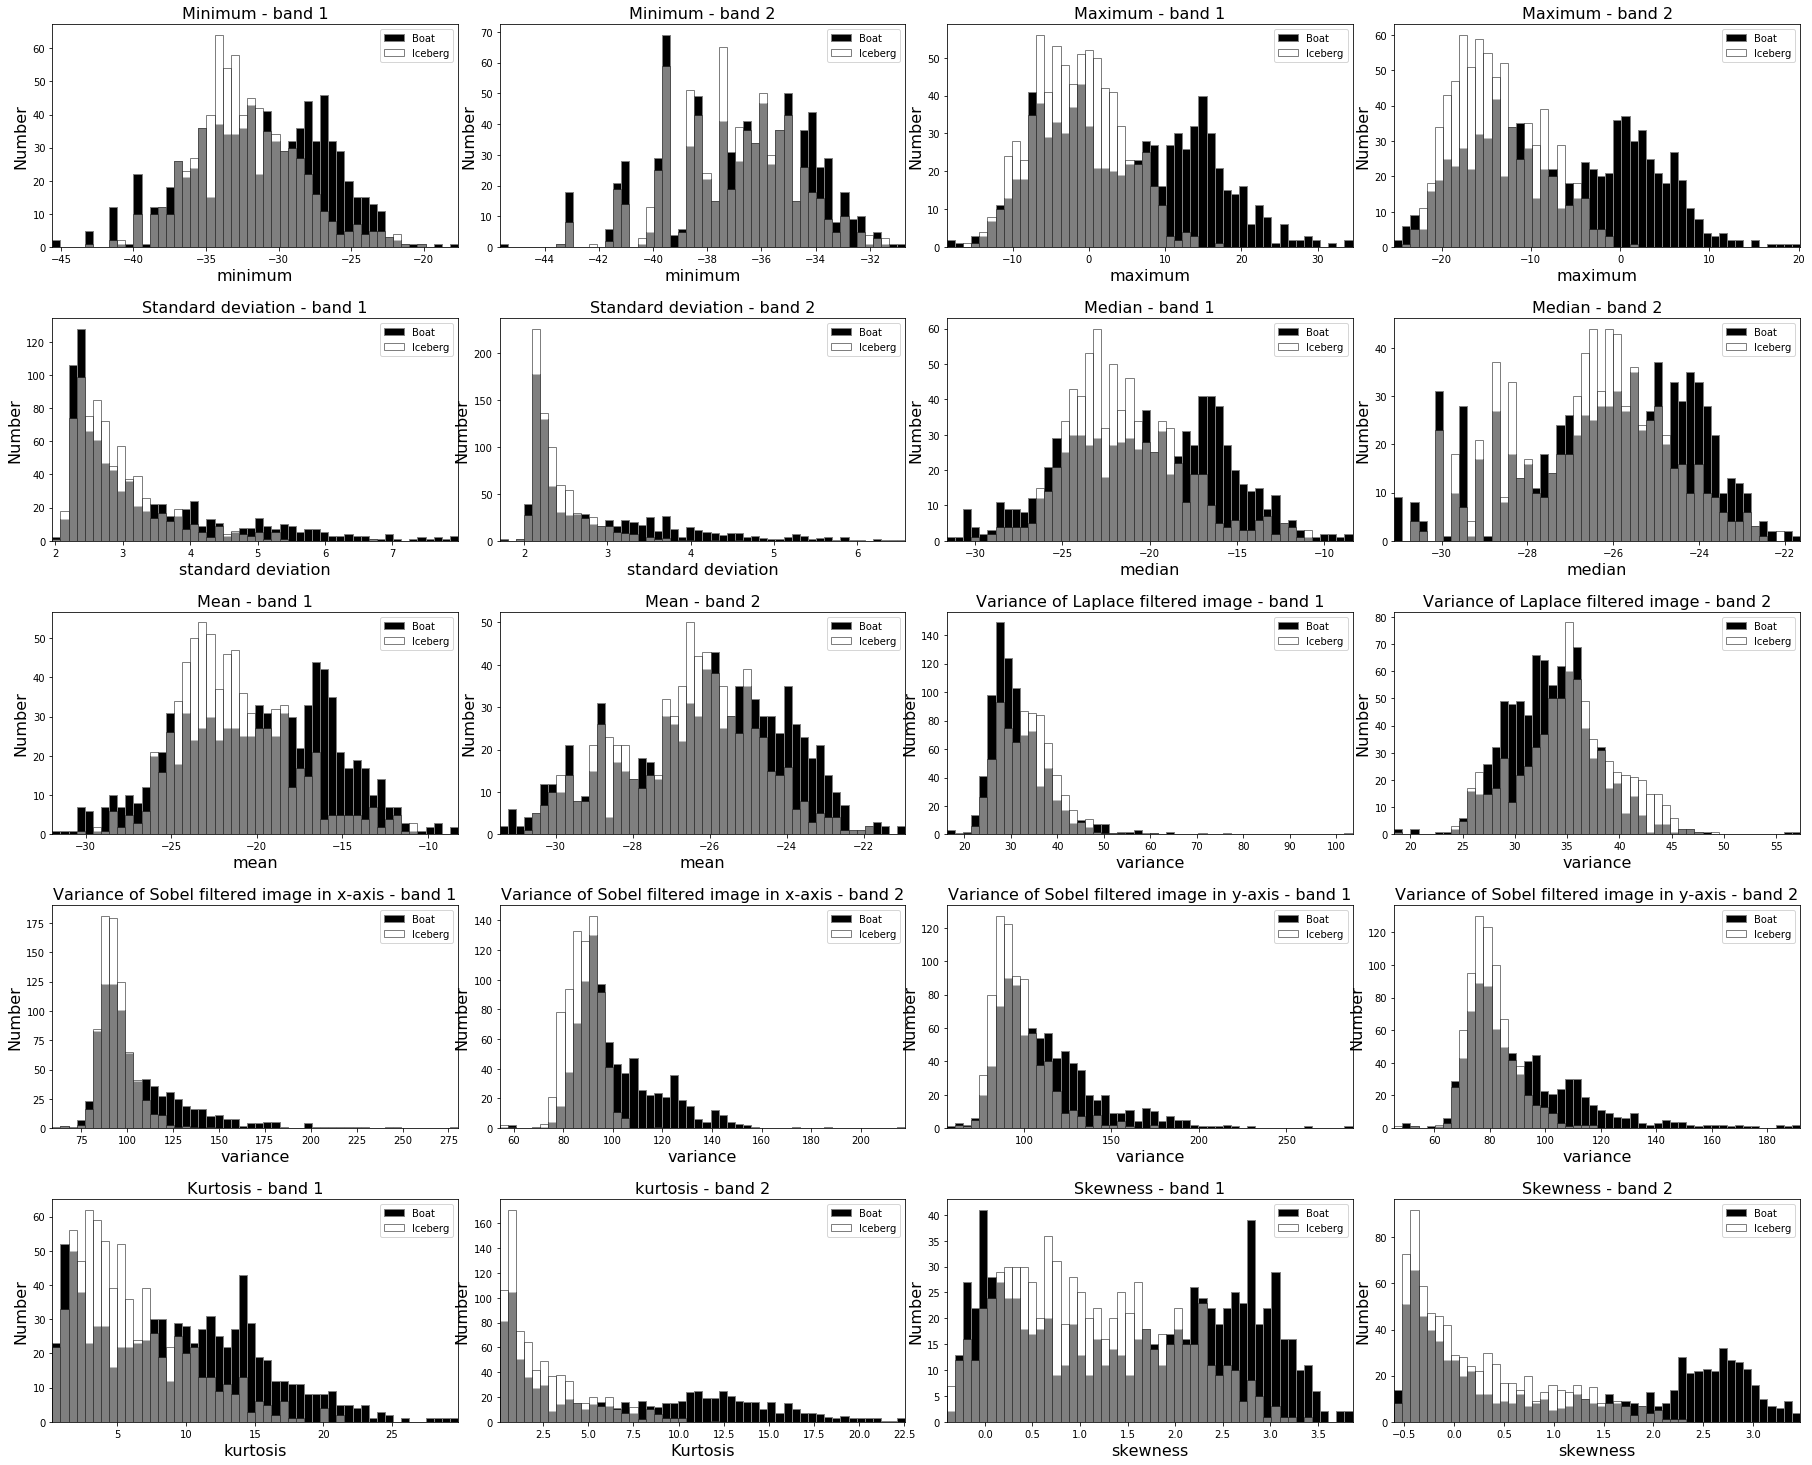

In [52]:
train = get_stats(train,1)
train = get_stats(train,2)
big_plot(columns, (5,4))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


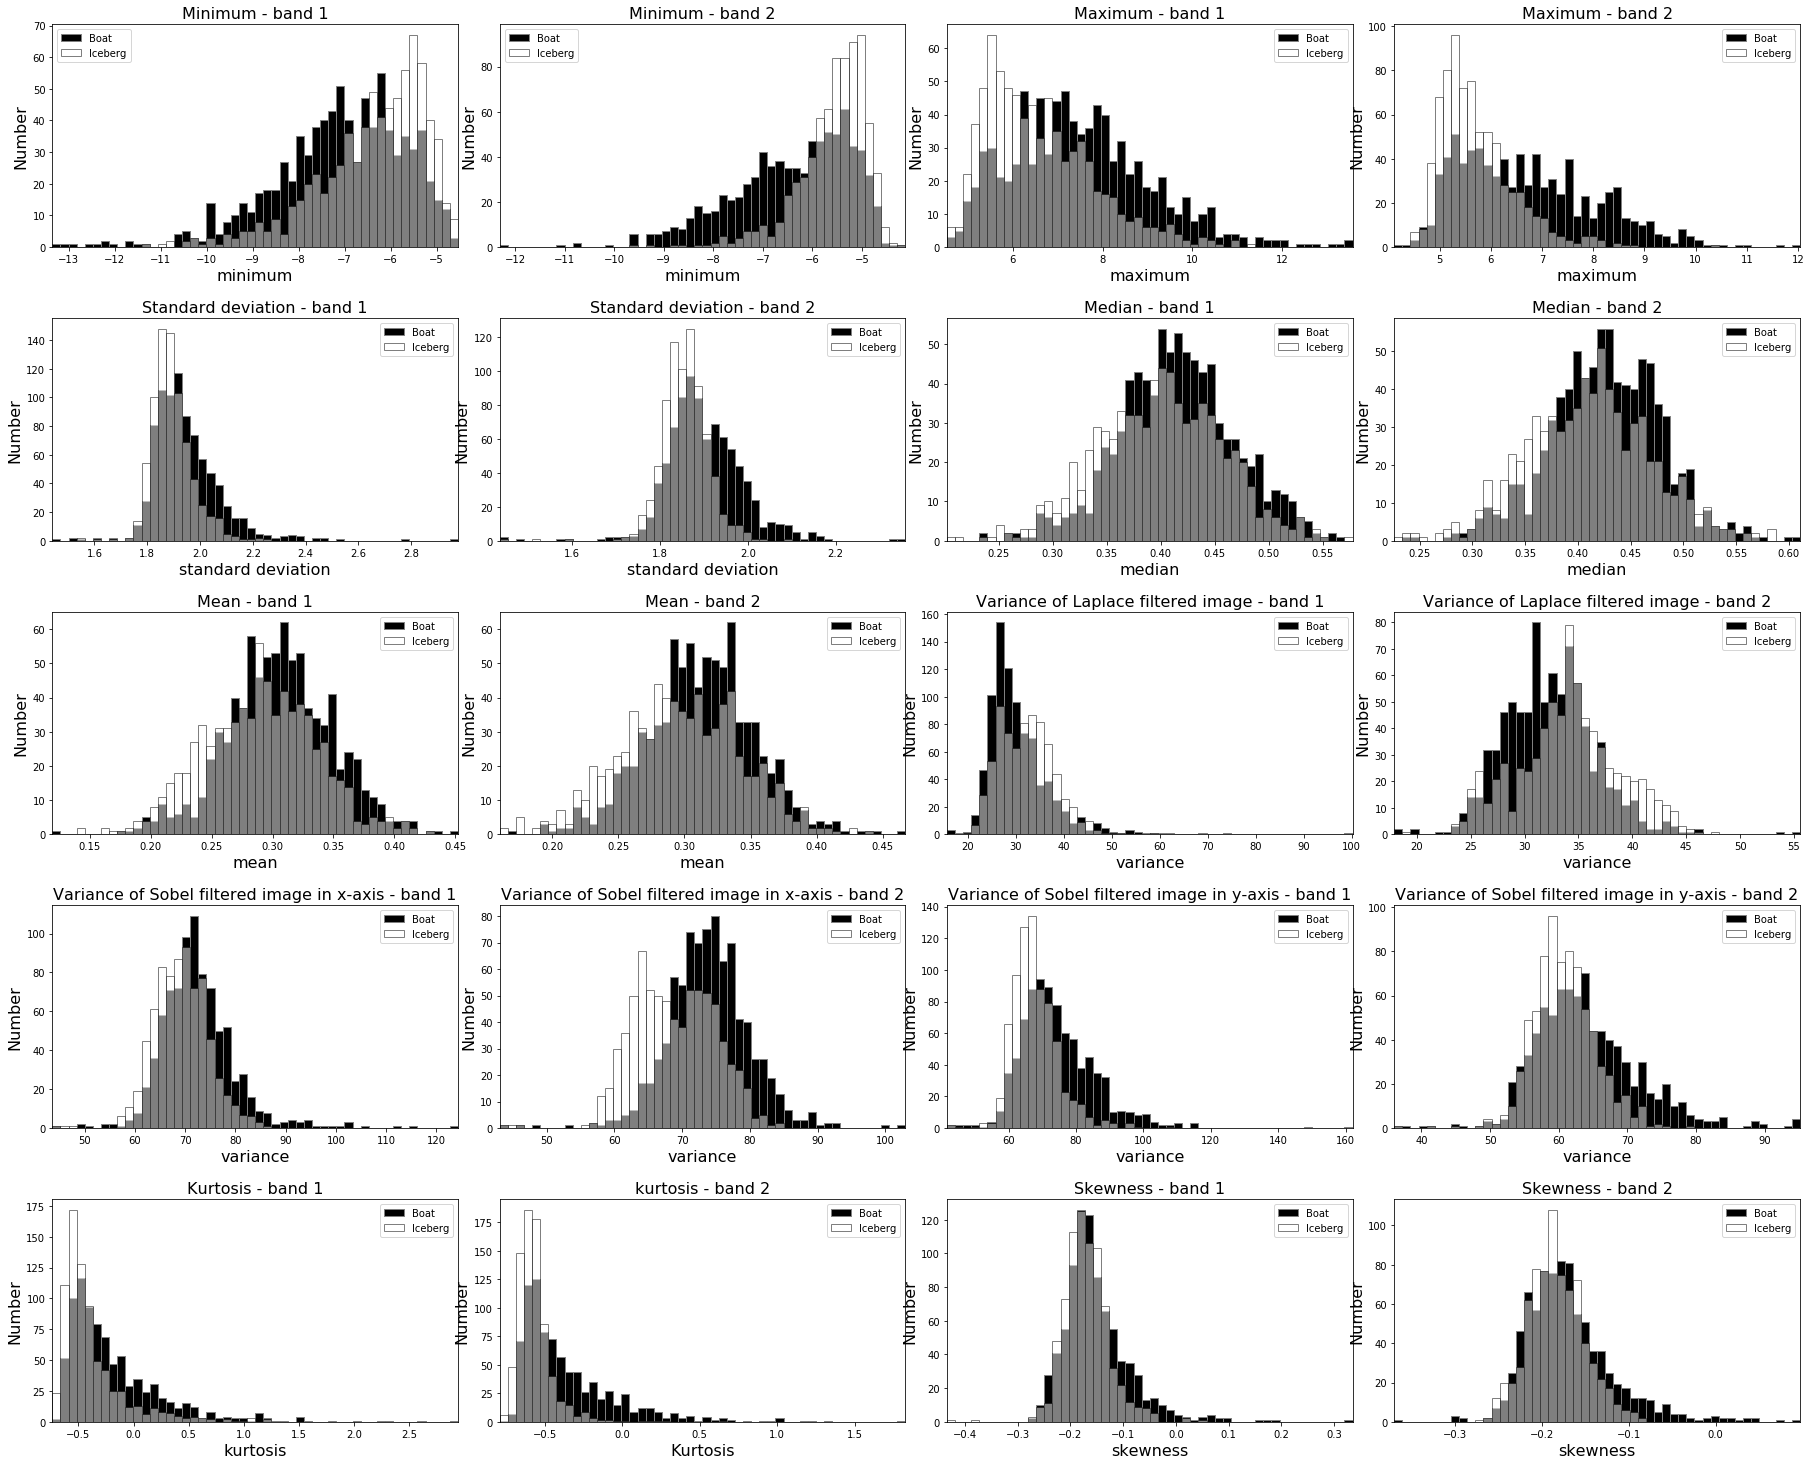

In [58]:
train = get_stats(train,1,imf=1)
train = get_stats(train,2,imf=1)
big_plot(columns, (5,4))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


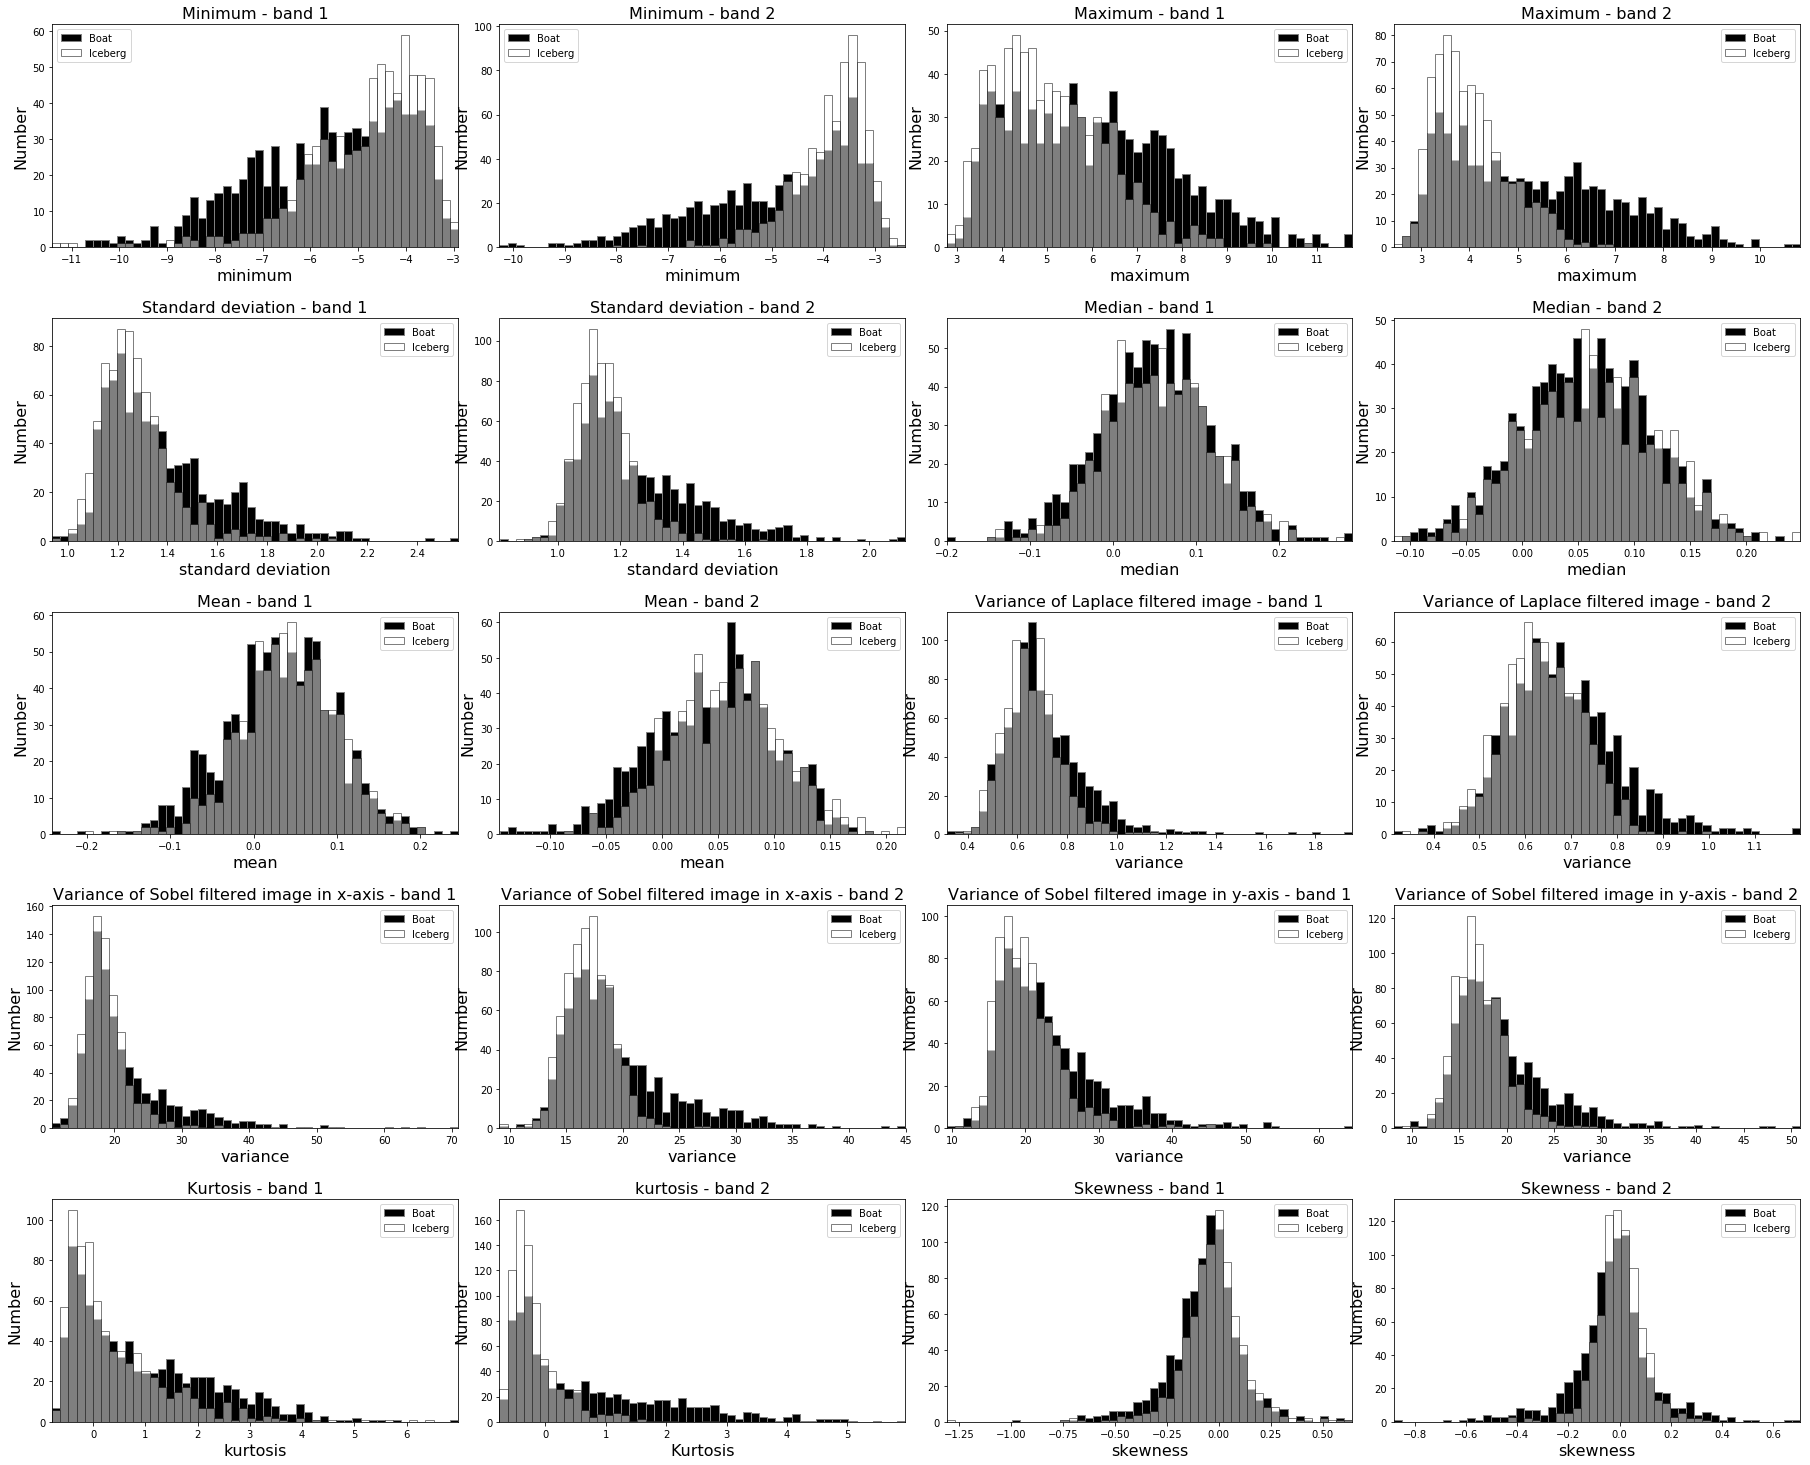

In [57]:
train = get_stats(train,1,imf=2)
train = get_stats(train,2,imf=2)
big_plot(columns, (5,4))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


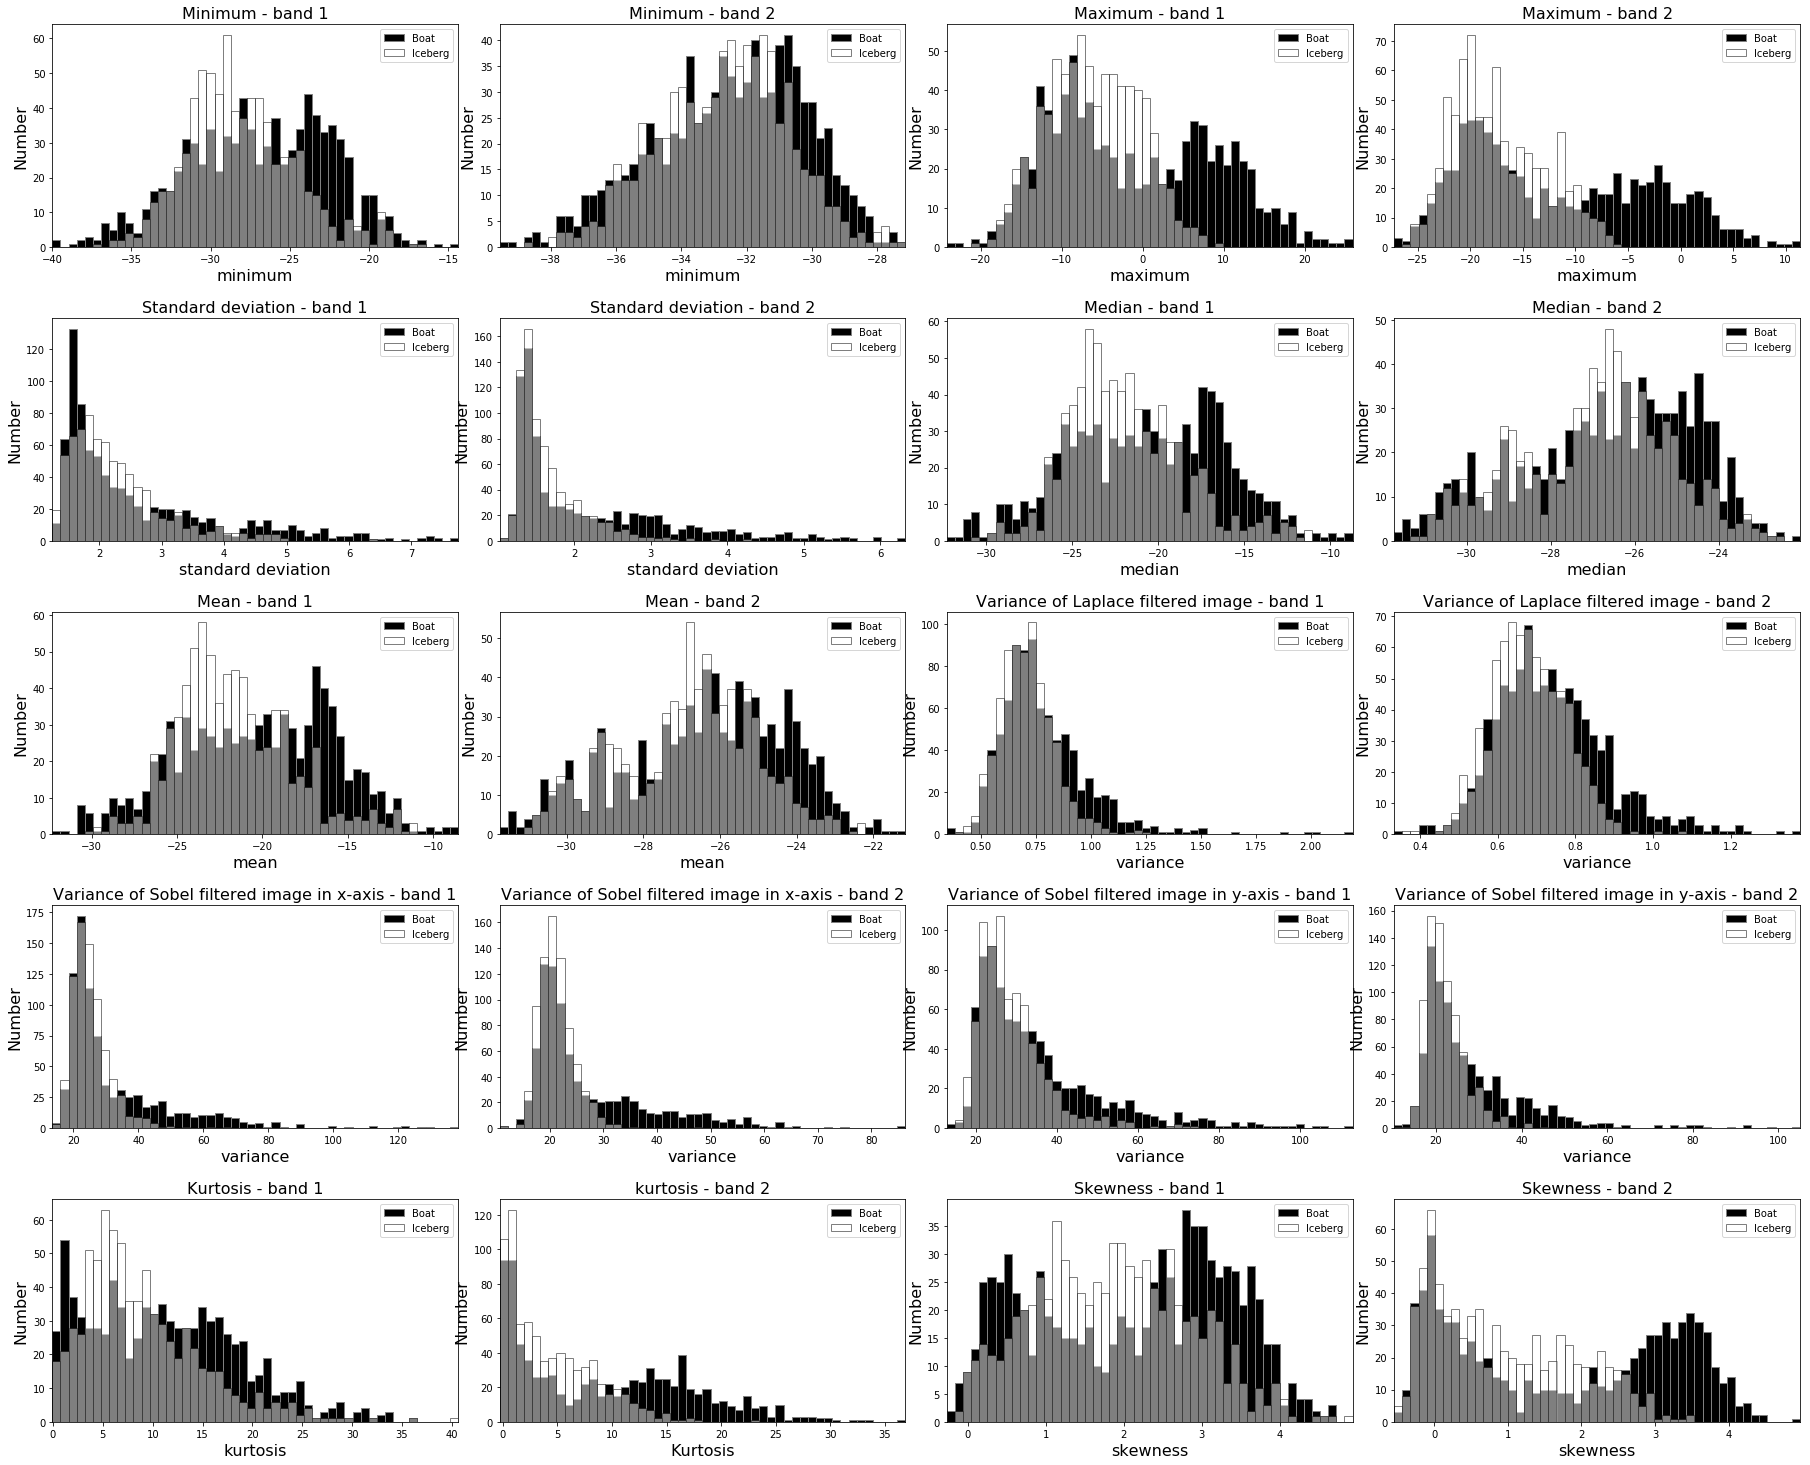

In [62]:
train = get_stats(train,1,res=1)
train = get_stats(train,2,res=1)
big_plot(columns, (5,4))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


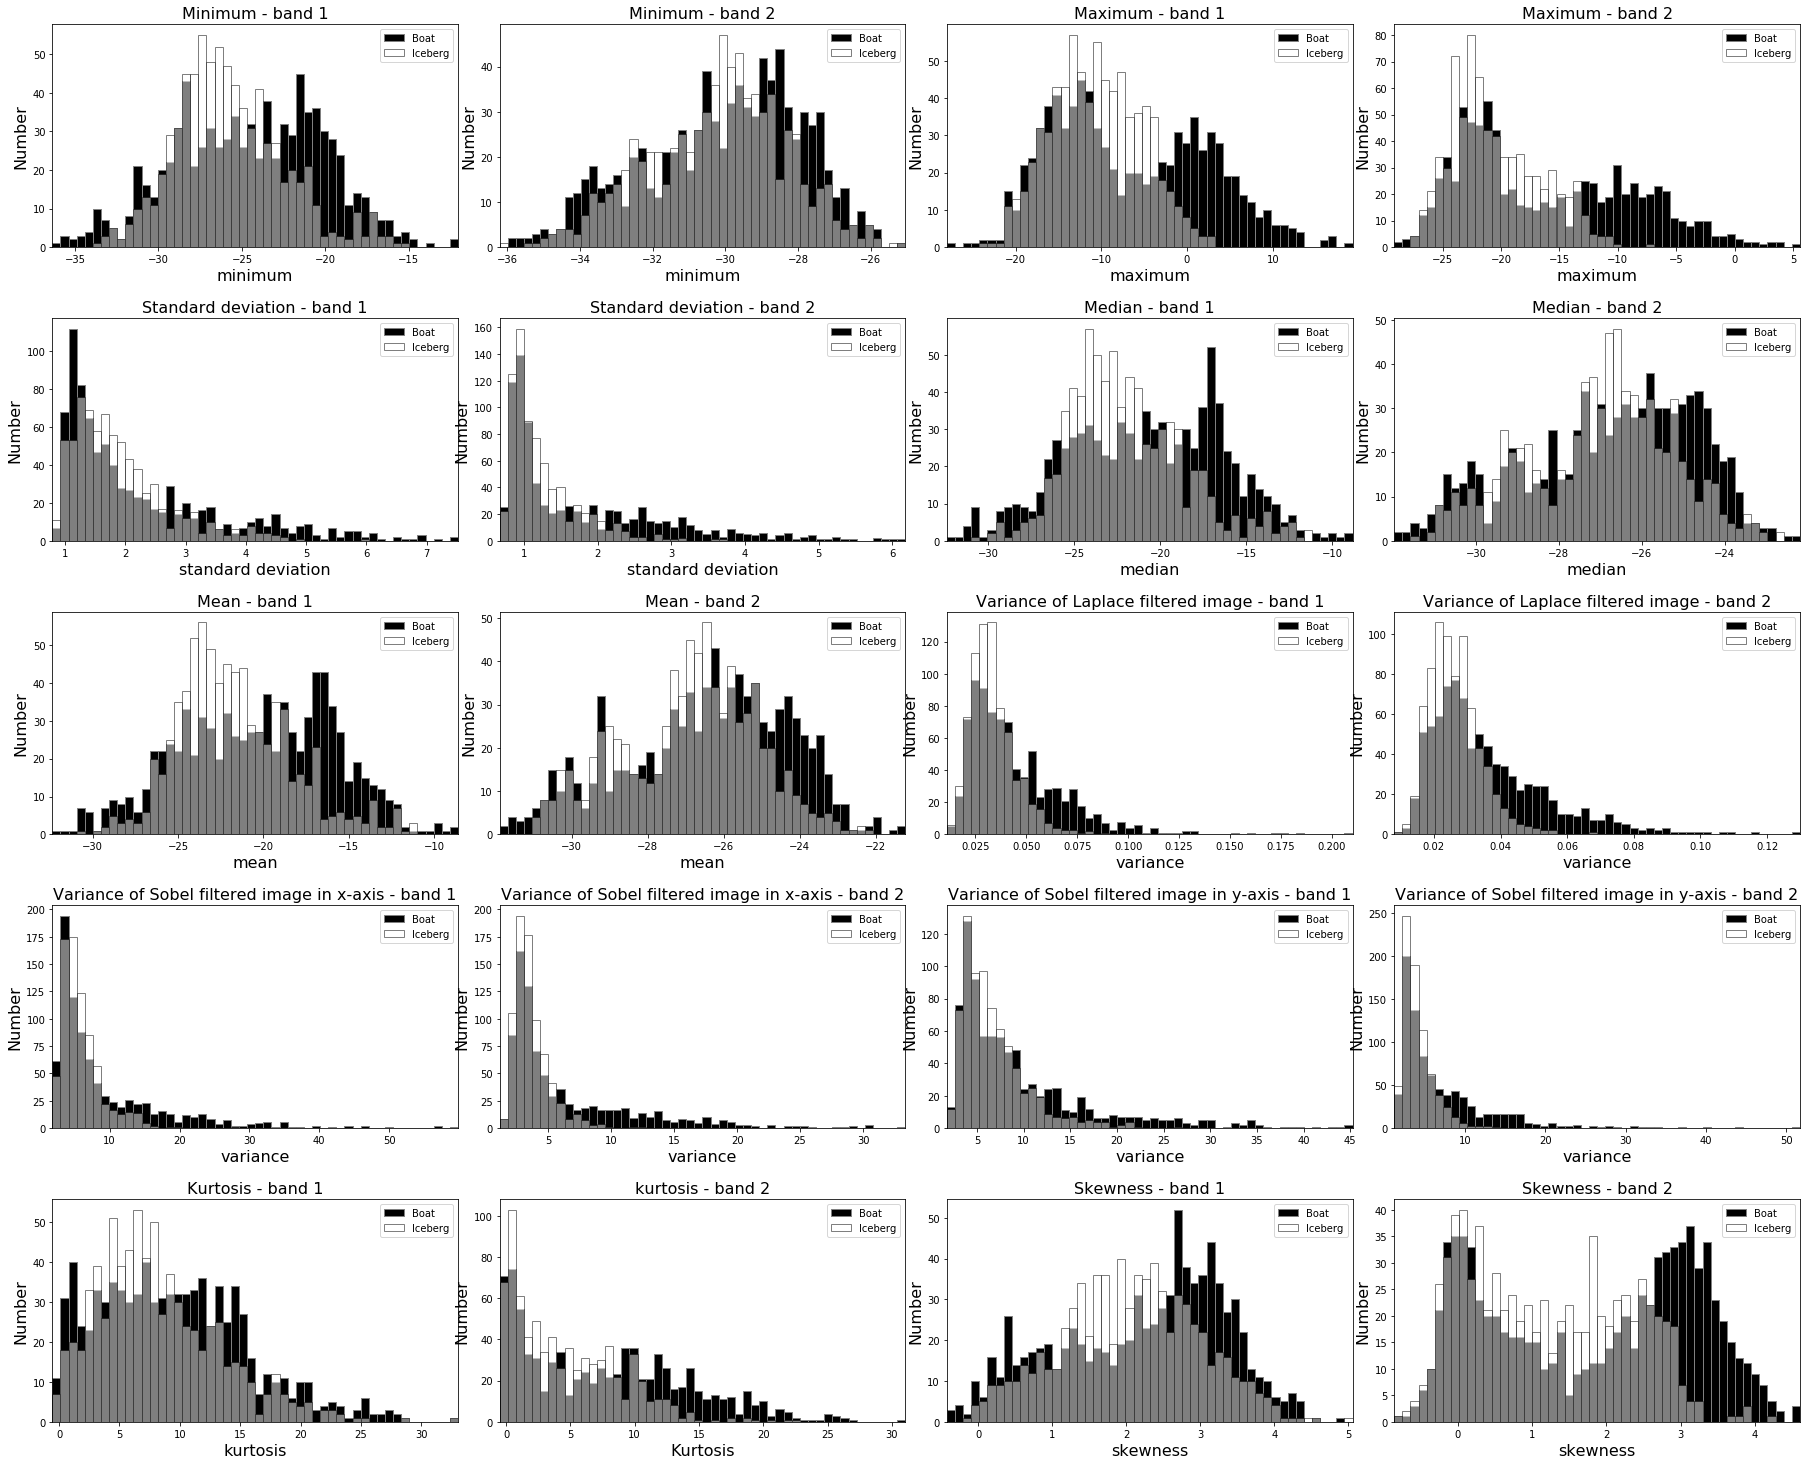

In [63]:
train = get_stats(train,1,res=2)
train = get_stats(train,2,res=2)
big_plot(columns, (5,4))